<img src="./Data/公式.png" style="zoom:50%;" />

In [ ]:
#pip install pyDOE

In [ ]:
from sympy import*
import numpy as np
from pyDOE import lhs         #Latin Hypercube Sampling
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   
import tensorflow as tf
from tensorflow import keras

# Setting

In [ ]:
x = symbols('x')
y = symbols('y')
t = symbols('t')

a = v1 = v2 = k =1 #a=4 ,v1=5,v2=10,k=1/4
c1 = 1 + v1/k ;c2 = -v1/v2;c3 = c2 - c1
g1 = g2 =0

u1 = a*x*(1-x)*(1-y)*exp(-t)
u2 = a*x*(1-x)*(c1 + c2*y + c3*y**2)*exp(-t)

f1 = diff(u1,t) - v1*( diff(u1,x,2) + diff(u1,y,2))
f2 = diff(u2,t) - v2*( diff(u2,x,2) + diff(u2,y,2))

u1 = lambdify((x,y,t),u1)
u2 = lambdify((x,y,t),u2)

f1 = lambdify((x,y,t),f1,'tensorflow')
f2 = lambdify((x,y,t),f2,'tensorflow')

# Define

In [ ]:
def trainingdata(N_u,N_f,N_i,omga,u,interface):    
    '''
      x1 = x,  x2 = y
      interface = 0, 则x2_range[0] 作为 interface ； interfacer = 1 则 x2_range[1]作为interface
    
      Return: X_u_train (N_u x 3),u_train (N_u x 1), X_f_train (N_f x 3), X_i_train (N_i x 3)
    '''
    x1_range = omga[0]
    x2_range = omga[1]
    t_range = [0.,1.]
    
    x1 = np.linspace(x1_range[0],x1_range[1],N_u)
    x2 = np.linspace(x2_range[0],x2_range[1],N_u)
    t = np.linspace(t_range[0],t_range[1],N_u)
    
    # Initial Condition t=0 , x1_range[0]<= x1 <= x_range[1] , x2_range[0] <= x2 <= x2_range[1]
    X1,X2 = np.meshgrid(x1,x2)
    X1 = X1.reshape((N_u**2,1))
    X2 = X2.reshape((N_u**2,1))
    T = np.ones(shape=(N_u**2,1)) * t_range[0]

    initial_X = np.hstack([X1,X2,T])
    initial_u = u(X1,X2,T)

    # BC_left: x1=x1_range[0], 0<=t<=1, x2_range[0] <= x2 <= x2_range[1]
    X2,T = np.meshgrid(x2,t)
    X2 = X2.reshape((N_u**2,1))
    T = T.reshape((N_u**2,1))
    X1 = np.ones(shape=(N_u**2,1)) * x1_range[0]

    leftedge_X = np.hstack([X1,X2,T])
    leftedge_u = u(X1,X2,T)
    
    # BC_right: x1=x1_range[1], 0<=t<=1, x2_range[0] <= x2 <= x2_range[1]
    X2,T = np.meshgrid(x2,t)
    X2 = X2.reshape((N_u**2,1))
    T = T.reshape((N_u**2,1))
    X1 = np.ones(shape=(N_u**2,1)) * x1_range[1]

    rightedge_X = np.hstack([X1,X2,T])
    rightedge_u = u(X1,X2,T)

    # BC_top or BC_bottom ,depends on interface. x2 = x2_range[bc], 0<=t<=1 ,x1_range[0]<= x1 <= x_range[1]
    bc = (interface+1)%2
    X1,T = np.meshgrid(x1,t)
    X1 = X1.reshape((N_u**2,1))
    T = T.reshape((N_u**2,1))
    X2 = np.ones(shape=(N_u**2,1)) * x2_range[bc]

    BC_X = np.hstack([X1,X2,T])
    BC_u = u(X1,X2,T)
    
    all_X_u_train =  np.vstack([initial_X,leftedge_X,rightedge_X,BC_X])
    all_u_train = np.vstack([initial_u,leftedge_u,rightedge_u,BC_u])
    
    idx = np.random.choice(all_X_u_train.shape[0], N_u*3, replace=False) 
    
    X_u_train = all_X_u_train[idx,:]
    u_train = all_u_train[idx,:]
    
    # BC_interface: x2 = x2_range[interface], 0<=t<=1 ,x1_range[0]<= x1 <= x_range[1]
    x1 = np.linspace(x1_range[0],x1_range[1],N_i)
    t = np.linspace(t_range[0],t_range[1],N_i)
    X1,T = np.meshgrid(x1,t)
    X1 = X1.reshape((N_i**2,1))
    T = T.reshape((N_i**2,1))
    X2 = np.ones(shape=(N_i**2,1)) * x2_range[interface]
    interface_X = np.hstack([X1,X2,T])    
            
    idx = np.random.choice(interface_X.shape[0], N_i, replace=False) 
    X_i_train = interface_X[idx,:]        
            
    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x1,x2,t)
    lb = np.array([x1_range[0],x2_range[0],t_range[0]])
    ub = np.array([x1_range[1],x2_range[1],t_range[1]])
    X_f_train = lb + (ub-lb)*lhs(3,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    return X_u_train,u_train,X_f_train,X_i_train

In [ ]:
class MyPinn(keras.Sequential): 
    def __init__(self,Layers,v,n,k,f,name = None): #Layers=[3,20,20,1]
        super(MyPinn, self).__init__(name=name)
        self.add(keras.Input(shape=(Layers[0],) ,dtype=tf.float64))
        for i in range(1,len(Layers)-1):
            self.add(keras.layers.Dense(Layers[i], dtype=tf.float64, activation='tanh'))
        self.add(keras.layers.Dense(Layers[-1],dtype=tf.float64, name="outputs"))
        self.v = tf.constant(v,dtype=tf.float64)
        self.n = tf.constant(n,dtype=tf.float64)
        self.k = tf.constant(k,dtype=tf.float64)
        self.f = f
        
    @tf.function
    def loss_U(self,X_u_train,u_train):
        u= self(X_u_train)
        loss_u = tf.reduce_mean(tf.square(u_train - u))
        return loss_u
        
    @tf.function
    def loss_PDE(self,X_f_train):
        x = X_f_train[:,0:1]
        y = X_f_train[:,1:2]
        t = X_f_train[:,2:3]
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([x,y,t])
            X = tf.stack([x[:,0],y[:,0],t[:,0]],axis=1)
            u = self(X)  
            u_x = tape.gradient(u,x)
            u_y = tape.gradient(u,y)
            #u_t = tape.gradient(u,t)
        #tf.print(u_x)    
        u_t = tape.gradient(u, t)     
        u_xx = tape.gradient(u_x, x)
        u_yy = tape.gradient(u_y, y)

        del tape
      
        loss_f = u_t - self.v *(u_xx + u_yy) - self.f(x,y,t)
        loss_f = tf.reduce_mean(tf.square(loss_f))
        return loss_f
        
    @tf.function
    def train_loop(self,X_u_train,u_train,X_f_train):
      with tf.GradientTape() as tape:
        loss = self.loss_U(X_u_train,u_train) + self.loss_PDE(X_f_train)
      gradients = tape.gradient(loss,self.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

      return loss

    def train(self,X_u_train,u_train,X_f_train,epochs=200):
      for epoch in tf.range(1,epochs+1):
          loss = self.train_loop(X_u_train,u_train,X_f_train)
          if epoch % 50 == 0:                
              tf.print(
                  "Training loss (for per 10 epoches) at epoch ",epoch,":",loss
              )

In [ ]:
@tf.function
def loss_I(m1,m2,X_i_train):
    x = X_i_train[:,0:1]
    y = X_i_train[:,1:2]
    t = X_i_train[:,2:3]
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x,y,t])
        X = tf.stack([x[:,0],y[:,0],t[:,0]],axis=1)
        U1 = m1(X)
        U2 = m2(X)
    
    U1_x = tape.gradient(U1, x)
    U1_y = tape.gradient(U1, y)
    U2_x = tape.gradient(U2, x)
    U2_y = tape.gradient(U2, y)

    del tape
    
    loss_u1 = -m1.v * ( U1_x*m1.n[0] + U1_y*m1.n[1]) - m1.k * (U1-U2)
    loss_u2 = -m2.v * ( U2_x*m2.n[0] + U2_y*m2.n[1]) - m2.k * (U2-U1)

    loss_i = tf.reduce_mean(tf.square(loss_u1)) + tf.reduce_mean(tf.square(loss_u2))

    return loss_i

In [ ]:
@tf.function
def train_step(m1,m2,X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train):
    
    with tf.GradientTape(persistent=True) as tape:
        loss_m1 = m1.loss_U(X_u1_train,u1_train) + m1.loss_PDE(X_f1_train)
        loss_m2 = m2.loss_U(X_u2_train,u2_train) + m2.loss_PDE(X_f2_train)
        loss_i = loss_I(m1,m2,X_i_train)
        loss = loss_m1 + loss_m2 + loss_i
        
    gradients_m1 = tape.gradient(loss,m1.trainable_variables)
    gradients_m2 = tape.gradient(loss,m2.trainable_variables)
    
    del tape
    
    m1.optimizer.apply_gradients(zip(gradients_m1, m1.trainable_variables))
    m2.optimizer.apply_gradients(zip(gradients_m2, m2.trainable_variables))
    
    return loss

def ds_train_n_batch(X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train,n = 5):
    batch_u1 = int(len(X_u1_train)/n) # = int(len(u1_train)/n)
    batch_f1 = int(len(X_f1_train)/n)

    batch_u2 = int(len(X_u2_train)/n) # = int(len(u2_train)/n)
    batch_f2 = int(len(X_f2_train)/n)
    
    batch_i = int(len(X_i_train)/n)
    
    ds_u1 = tf.data.Dataset.from_tensor_slices( ((X_u1_train,u1_train)) ).batch( batch_u1 )
    ds_f1 = tf.data.Dataset.from_tensor_slices( X_f1_train ).batch( batch_f1 )
    
    ds_u2 = tf.data.Dataset.from_tensor_slices( ((X_u2_train,u2_train)) ).batch( batch_u2 )
    ds_f2 = tf.data.Dataset.from_tensor_slices( X_f2_train ).batch( batch_f2 )
    
    ds_i = tf.data.Dataset.from_tensor_slices(X_i_train).batch(batch_i)

    ds = tf.data.Dataset.zip((ds_u1,ds_f1,ds_u2,ds_f2,ds_i))
    return ds


def train_model(m1,m2,ds,epochs = 100):
    for epoch in tf.range(1,epochs+1):
            for (x_u1,u1),x_f1,(x_u2,u2),x_f2,x_i in ds:
                loss = train_step(m1,m2,x_u1,u1,x_f1,x_u2,u2,x_f2,x_i)
            if epoch % 50 == 0:                
                tf.print(
                  "Training loss (for per 50 epoches) at epoch ",epoch,":",loss
                )

# Train

In [ ]:
n1 = [0.,-1.]
n2 = [0.,1.]

omga1 = [[0.,1.],[0.,1.]]  # (x,y)的取值范围 
omga2 = [[0.,1.],[-1.,0.]] 

N_i = 300

N_u1 = 300; N_f1 = 2000  ;omga = omga1; interface=0; u = u1
X_u1_train,u1_train,X_f1_train,X_i_train= trainingdata(N_u1,N_f1,N_i,omga,u,interface)


N_u2 = 300; N_f2= 2000 ; omga = omga2; interface=1; u = u2
X_u2_train,u2_train,X_f2_train,X_i_train= trainingdata(N_u2,N_f2,N_i,omga,u,interface)

In [ ]:
Layers=[3,20,20,20,20,20,20,20,1]
model_u1 = MyPinn(Layers,v1,n1,k,f1,name="model_1")
model_u1.compile(optimizer=keras.optimizers.Adam())

model_u2 = MyPinn(Layers,v2,n2,k,f2,name="model_2")
model_u2.compile(optimizer=keras.optimizers.Adam())

ds = ds_train_n_batch(X_u1_train, u1_train , X_f1_train , X_u2_train , u2_train , X_f2_train , X_i_train ,n = 5)

In [ ]:
train_model(model_u1,model_u2,ds,epochs=5000)

Training loss (for per 50 epoches) at epoch  2700 : 0.0013123949049505584
Training loss (for per 50 epoches) at epoch  2750 : 0.0023987772602955303
Training loss (for per 50 epoches) at epoch  2800 : 0.0015225533574499631
Training loss (for per 50 epoches) at epoch  2850 : 0.0048611765572324876
Training loss (for per 50 epoches) at epoch  2900 : 0.0009633301436103121
Training loss (for per 50 epoches) at epoch  2950 : 0.0014124294433345724
Training loss (for per 50 epoches) at epoch  3000 : 0.00343534219857984
Training loss (for per 50 epoches) at epoch  3050 : 0.0020774584357714969
Training loss (for per 50 epoches) at epoch  3100 : 0.0015532015217561775
Training loss (for per 50 epoches) at epoch  3150 : 0.0036586503135883222
Training loss (for per 50 epoches) at epoch  3200 : 0.0008681421665606428
Training loss (for per 50 epoches) at epoch  3250 : 0.002801952954147958
Training loss (for per 50 epoches) at epoch  3300 : 0.0012198034627318053
Training loss (for per 50 epoches) at epo

In [ ]:
'''
u1_i = u1(X_i_train[:,0],X_i_train[:,1],X_i_train[:,2])
u2_i = u2(X_i_train[:,0],X_i_train[:,1],X_i_train[:,2])
u1_i = u1_i.reshape((u1_i.shape[0],1))
u2_i = u1_i.reshape((u2_i.shape[0],1))

X_u1_train_ = tf.concat([X_u1_train,X_i_train],axis=0)
X_u2_train_ = tf.concat([X_u2_train,X_i_train],axis=0)
u1_train_ = tf.concat([u1_train,u1_i],axis=0)
u2_train_ = tf.concat([u2_train,u2_i],axis=0) 
'''

In [ ]:
model_u1.train(X_u1_train,u1_train,X_f1_train,epochs=5000) #单区域PINN训练
model_u2.train(X_u2_train,u2_train,X_f2_train,epochs=5000) #单区域PINN训练

In [ ]:
"""history_u1 = model_u1.fit(
    X_u1_train,
    u1_train,
    batch_size=64,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    #validation_data=(x_val, y_val),
)
history_u2 = model_u2.fit(
    X_u2_train,
    u2_train,
    batch_size=64,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    #validation_data=(x_val, y_val),
)"""

# TestData

In [ ]:
omga1 = [[0.,1.],[0.,1.]]  # (x,y)的取值范围 
omga2 = [[0.,1.],[-1.,0.]] 
def test_data(N,omga,u,t=1.):
  # Output: X,Y,T,U shape=(N,N)
  x_range = tf.linspace(omga[0][0],omga[0][1],N)
  y_range = tf.linspace(omga[1][0],omga[1][1],N)

  X,Y = tf.meshgrid(x_range,y_range)
  T = tf.ones(shape=X.shape)*t
  U = u(X,Y,T)
  return X,Y,T,U

def pred_data(X,Y,T,model):
  #Input: X,Y,T shape=(N,N)
  #Output: U_pred shape=(N,N)
  Shape = X.shape
  dim = len(Shape)
  X = tf.reshape(X,shape=(Shape[0]**dim,1))
  Y = tf.reshape(Y,shape=(Shape[0]**dim,1))
  T = tf.reshape(T,shape=(Shape[0]**dim,1))

  Inputs = tf.concat([X,Y,T],axis=1)
  U_pred = model(Inputs)
  U_pred = tf.reshape(U_pred,shape=Shape)
  return U_pred
  
N = 100
X_u1,Y_u1,T_u1,U1 = test_data(N,omga1,u1,t=1.0)
U1_pred = pred_data(X_u1,Y_u1,T_u1,model_u1)

X_u2,Y_u2,T_u2,U2 = test_data(N,omga2,u2,t=1.0)
U2_pred = pred_data(X_u2,Y_u2,T_u2,model_u2)

# Plot

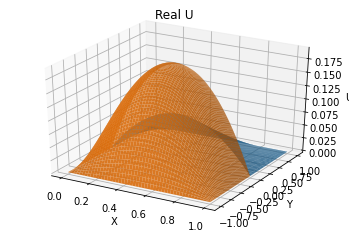

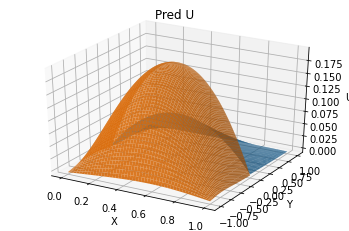

In [ ]:

####################################################
plt.figure(1) 
ax1 = plt.axes(projection="3d")
ax1.patch.set_facecolor("white")   #设置 axes 背景颜色

ax1.plot_surface(X_u1,Y_u1,U1,alpha=0.9) #生成曲面z，alpha调节透明度，cmap调节曲面色调
ax1.plot_surface(X_u2,Y_u2,U2,alpha=0.9)

ax1.set_xlabel("X")   
ax1.set_ylabel("Y")
ax1.set_zlabel("U")
ax1.set_title("Real U")
######################################################
plt.figure(2) 
ax2 = plt.axes(projection="3d")
ax2.patch.set_facecolor("white") 

### u1
ax2.plot_surface(X_u1,Y_u1,U1_pred,alpha=0.9)

###u2
ax2.plot_surface(X_u2,Y_u2,U2_pred,alpha=0.9)

ax2.set_xlabel("X")   
ax2.set_ylabel("Y")
ax2.set_zlabel("U")
ax2.set_title("Pred U")
###############################
plt.show()

In [ ]:
u1_real = U1.numpy().flatten()
u1_pred = U1_pred.numpy().flatten()

error_u1 = np.linalg.norm((u1_real-u1_pred),2)/np.linalg.norm(u1_real,2)  
print('Test Error For u1:  %.5f'  % (error_u1))

u2_real = U2.numpy().flatten()
u2_pred = U2_pred.numpy().flatten()
error_u2 = np.linalg.norm((u2_real-u2_pred),2)/np.linalg.norm(u2_real,2)  
print('Test Error For u2:  %.5f'  % (error_u2))


Test Error For u1:  0.05713
Test Error For u2:  0.02445
